In [1]:
%config InlineBackend.figure_formats = ['svg']

In [2]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['FreeSans']

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
state_dim = 64
num_actions = 25
horizon = 20

In [5]:
from a5cpu_BCQ.model import BCQ
from a5cpu_BCQ.data import remap_rewards
from a5cpu_BCQ.data import EpisodicBuffer as EpisodicBufferOO
from a7cpu_BCQf.model import BCQf
from a7cpu_BCQf.data import EpisodicBuffer as EpisodicBufferFF
from a7cpu_BCQf.model import all_subactions_vec

In [6]:
from evaluate import (
    EpisodicBufferO, offline_evaluation_O,
    EpisodicBufferF, offline_evaluation_F,
)

In [7]:
from types import SimpleNamespace
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

In [8]:
df_1_best = pd.read_csv('best_BCQ_meta.csv')
df_2_best = pd.read_csv('best_BCQf_meta.csv')

In [9]:
df_1_best

,index,iteration,val_qvalues,val_wis,val_ess,epoch,created_at,version,threshold,seed
0,97,9800.0,11.247806,92.497391,202.913132,5,2021-11-15 19:47:41.309691,17,0.5,1


In [10]:
df_2_best

,index,iteration,val_qvalues,val_wis,val_ess,epoch,created_at,version,threshold,seed
0,90,9100.0,10.518903,93.28846,216.866272,5,2021-11-15 19:51:43.311177,27,0.5,4


In [11]:
df_1_best['version'].item()

17

In [12]:
model_1 = BCQ.load_from_checkpoint(
    checkpoint_path=f'../a5cpu_BCQ/logs/mimic_dBCQ/version_{df_1_best["version"].item()}/checkpoints/step={int(df_1_best["iteration"].item()-1)}.ckpt', 
    map_location=None)
model_1.eval()

model_2 = BCQf.load_from_checkpoint(
    checkpoint_path=f'../a7cpu_BCQf/logs/mimic_dBCQf/version_{df_2_best["version"].item()}/checkpoints/step={int(df_2_best["iteration"].item()-1)}.ckpt', 
    map_location=None)
model_2.eval()
model_2.all_subactions_vec = all_subactions_vec

In [13]:
test_episodes_O = EpisodicBufferO(state_dim, num_actions, horizon)
test_episodes_O.load('../data/episodes+encoded_state+knn_pibs/test_data.pt')
test_episodes_O.reward = remap_rewards(test_episodes_O.reward, SimpleNamespace(**{'R_immed': 0.0, 'R_death': 0.0, 'R_disch': 100.0}))

tmp_test_episodes_loader_O = DataLoader(test_episodes_O, batch_size=len(test_episodes_O), shuffle=False)
test_batch_O = next(iter(tmp_test_episodes_loader_O))

Episodic Buffer loaded with 2894 episides.


In [14]:
test_wis_1, test_ess_1 = model_1.offline_evaluation(test_batch_O, weighted=True, eps=0.01)
test_wis_2, test_ess_2 = offline_evaluation_O(model_2, test_batch_O, weighted=True, eps=0.01)

In [15]:
print(f'Observed Test \t WIS: {test_episodes_O.reward.sum(axis=1).mean():.2f} \t ESS: {test_episodes_O.reward.shape[0]:.2f}')
print(f'Baseline BCQ \t WIS: {test_wis_1:.2f} \t ESS: {test_ess_1:.2f}')
print(f'Factored BCQ \t WIS: {test_wis_2:.2f} \t ESS: {test_ess_2:.2f}')

Observed Test 	 WIS: 90.29 	 ESS: 2894.00
Baseline BCQ 	 WIS: 90.44 	 ESS: 178.32
Factored BCQ 	 WIS: 91.62 	 ESS: 178.32


In [16]:
states, actions, rewards, not_dones, pibs, estm_pibs = test_batch_O
n, horizon, _ = states.shape

action_pred_1 = []
for idx in tqdm(range(n)):
    lng = (not_dones[idx, :, 0].sum() + 1).item()  # all but the final transition has notdone==1

    # Predict Q-values and Imitation probabilities
    q, imt, _ = model_1.Q(states[idx])
    imt = imt.exp()
    imt = (imt / imt.max(1, keepdim=True).values > model_1.threshold).float()

    # Use large negative number to mask actions from argmax
    a_id = (imt * q + (1. - imt) * torch.finfo().min).argmax(axis=1).cpu().numpy()
    a_id[lng:] = -1
    action_pred_1.append(a_id)

100%|██████████| 2894/2894 [00:05<00:00, 523.02it/s]


In [17]:
action_pred_1 = np.array(action_pred_1)

In [18]:
action_pred_1

array([[ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       ...,
       [ 0,  5,  5, ..., -1, -1, -1],
       [ 5,  6,  8, ...,  8,  8, -1],
       [ 5,  5,  5, ...,  5,  5, -1]])

In [19]:
df_action_pred_1 = pd.DataFrame(action_pred_1.flatten(), columns=['a:action'])

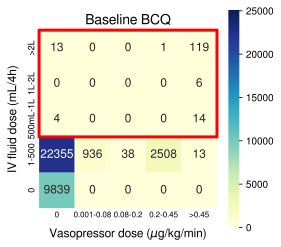

In [22]:
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(df_action_pred_1['a:action'].value_counts().sort_index().reindex(range(25), fill_value=0).values.reshape((5,5)), 
            ax=ax, square=True, cmap="YlGnBu", vmax=2.5e4, annot=True, fmt='d', annot_kws={"size": 12})
ax.invert_yaxis()

plt.title('Baseline BCQ', fontsize=14)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Vasopressor dose ($\mu$g/kg/min)", fontsize=12)
plt.ylabel("IV fluid dose (mL/4h)", fontsize=12)

xranges = ['0', '0.001-0.08', '0.08-0.2', '0.2-0.45', '>0.45']
yranges = ['0', '1-500', '500mL-1L', '1L-2L', '>2L']
for pos, text in enumerate(xranges):
    plt.text(pos+3/6, -0.2, text, fontsize=8, ha='center', va='center')
for pos, text in enumerate(yranges):
    plt.text(-0.2, pos+3/6, text, fontsize=9, ha='center', va='center', rotation='vertical')

plt.gca().add_patch(
    matplotlib.patches.Rectangle((0, 2), 5, 3, edgecolor='red', facecolor='none', lw=3, clip_on=False)
)

plt.savefig('./fig/mimic_test_policy_BCQ.pdf', bbox_inches='tight')
plt.show()

In [16]:
states, actions, rewards, not_dones, pibs, estm_pibs = test_batch_O
n, horizon, _ = states.shape

action_pred_2 = []
for idx in tqdm(range(n)):
    lng = (not_dones[idx, :, 0].sum() + 1).item()  # all but the final transition has notdone==1

    # Predict Q-values and Imitation probabilities
    q, _, i = model_2.Q(states[idx])
    imt = F.log_softmax(i.reshape(-1, 2, 5), dim=-1).exp()
    imt = (imt / imt.max(axis=-1, keepdim=True).values > model_2.threshold).float()

    # Factored action remapping
    q = q @ model_2.all_subactions_vec.T
    imt = torch.einsum('bi,bj->bji', (imt[:,0,:], imt[:,1,:])).reshape(-1, 25)

    # Use large negative number to mask actions from argmax
    a_id = (imt * q + (1. - imt) * torch.finfo().min).argmax(axis=1).cpu().numpy()
    a_id[lng:] = -1
    action_pred_2.append(a_id)

100%|██████████| 2894/2894 [00:05<00:00, 514.28it/s]


In [17]:
action_pred_2 = np.array(action_pred_2)

In [18]:
action_pred_2

array([[ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       ...,
       [ 0,  5,  5, ..., -1, -1, -1],
       [ 5,  5,  8, ...,  8,  8, -1],
       [ 5,  5,  5, ...,  5,  5, -1]])

In [19]:
df_action_pred_2 = pd.DataFrame(action_pred_2.flatten(), columns=['a:action'])

In [20]:
states, actions, rewards, not_dones, pibs, estm_pibs = test_batch_O
n, horizon, _ = states.shape

Q_est = []
for idx in tqdm(range(n)):
    lng = (not_dones[idx, :, 0].sum() + 1).item()  # all but the final transition has notdone==1

    # Predict Q-values and Imitation probabilities
    q, _, i = model_2.Q(states[idx])
    imt = F.log_softmax(i.reshape(-1, 2, 5), dim=-1).exp()
    imt = (imt / imt.max(axis=-1, keepdim=True).values > model_2.threshold).float()

    # Factored action remapping
    q = q @ model_2.all_subactions_vec.T
    imt = torch.einsum('bi,bj->bji', (imt[:,0,:], imt[:,1,:])).reshape(-1, 25)

    # Use large negative number to mask actions from argmax
    q_est = (imt * q + (1. - imt) * torch.finfo().min).detach().cpu().numpy()
    Q_est.append(q_est[:lng])

100%|██████████| 2894/2894 [00:05<00:00, 507.87it/s]


In [21]:
Q_est_ = np.concatenate(Q_est)

In [22]:
Q_est_.shape

(35846, 25)

In [23]:
from collections import Counter

In [24]:
Counter(Q_est_.reshape((-1,5,5)).max(axis=2).argmax(axis=1))

Counter({0: 9239, 1: 24694, 2: 1505, 4: 398, 3: 10})

In [25]:
Q_fluid = Q_est_.reshape((-1,5,5)).max(axis=2)

In [54]:
Counter(Q_fluid.argmax(axis=1))

Counter({0: 9239, 1: 24694, 2: 1505, 4: 398, 3: 10})

In [55]:
Q_large = Q_fluid[Q_fluid.argmax(axis=1) > 1]

In [69]:
order = Q_large.argsort(axis=1)
ranks = 4-order.argsort(axis=1)

In [70]:
Q_large

array([[-3.4028235e+38,  5.0177717e+00,  5.0600719e+00,  4.9691119e+00,
        -3.4028235e+38],
       [-3.4028235e+38,  8.1975079e+00,  8.2495613e+00, -3.4028235e+38,
        -3.4028235e+38],
       [-3.4028235e+38,  8.7948551e+00,  8.8132210e+00,  8.5537148e+00,
         9.0524225e+00],
       ...,
       [-3.4028235e+38,  5.2225399e+00,  5.2296309e+00,  5.1181293e+00,
        -3.4028235e+38],
       [-3.4028235e+38,  5.6003046e+00,  5.6178160e+00,  5.5083122e+00,
        -3.4028235e+38],
       [-3.4028235e+38,  5.7907658e+00,  5.8129721e+00,  5.7021866e+00,
        -3.4028235e+38]], dtype=float32)

In [71]:
ranks

array([[4, 1, 0, 2, 3],
       [4, 1, 0, 3, 2],
       [4, 2, 1, 3, 0],
       ...,
       [4, 1, 0, 2, 3],
       [4, 1, 0, 2, 3],
       [4, 1, 0, 2, 3]])

In [72]:
ranks.shape

(1913, 5)

In [81]:
Counter(ranks[:,2])

Counter({0: 1505, 1: 242, 2: 133, 3: 33})

In [82]:
Counter(ranks[:,3])

Counter({2: 751, 3: 1116, 0: 10, 1: 36})

In [84]:
Counter(ranks[:,4])

Counter({3: 707, 2: 798, 0: 398, 1: 10})

In [85]:
Counter(ranks[:,0])

Counter({4: 1913})

In [86]:
Counter(ranks[:,1])

Counter({1: 1625, 2: 231, 3: 57})

In [ ]:
# when x is optimal, 90% of time y is second best
# looking into incorporating previous approaches such as SVP to better handle this situation

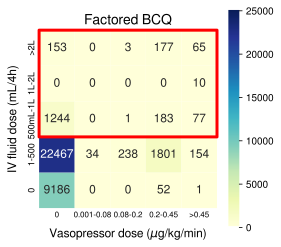

In [27]:
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(df_action_pred_2['a:action'].value_counts().sort_index().reindex(range(25), fill_value=0).values.reshape((5,5)), 
            ax=ax, square=True, cmap="YlGnBu", vmax=2.5e4, annot=True, fmt='d', annot_kws={"size": 12})
ax.invert_yaxis()

plt.title('Factored BCQ', fontsize=14)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Vasopressor dose ($\mu$g/kg/min)", fontsize=12)
plt.ylabel("IV fluid dose (mL/4h)", fontsize=12)

xranges = ['0', '0.001-0.08', '0.08-0.2', '0.2-0.45', '>0.45']
yranges = ['0', '1-500', '500mL-1L', '1L-2L', '>2L']
for pos, text in enumerate(xranges):
    plt.text(pos+3/6, -0.2, text, fontsize=8, ha='center', va='center')
for pos, text in enumerate(yranges):
    plt.text(-0.2, pos+3/6, text, fontsize=9, ha='center', va='center', rotation='vertical')

plt.gca().add_patch(
    matplotlib.patches.Rectangle((0, 2), 5, 3, edgecolor='red', facecolor='none', lw=3, clip_on=False)
)

plt.savefig('./fig/mimic_test_policy_BCQf.pdf', bbox_inches='tight')
plt.show()

In [28]:
states, actions, rewards, not_dones, pibs, estm_pibs = test_batch_O
n, horizon, _ = states.shape

action_obs = []
for idx in tqdm(range(n)):
    lng = (not_dones[idx, :, 0].sum() + 1).item()  # all but the final transition has notdone==1

    # Predict Q-values and Imitation probabilities
    q, imt, _ = model_1.Q(states[idx])
    imt = imt.exp()
    imt = (imt / imt.max(1, keepdim=True).values > model_1.threshold).float()

    # Use large negative number to mask actions from argmax
    a_id = actions[idx, :, 0].cpu().numpy()
    a_id[lng:] = -1
    action_obs.append(a_id)

100%|██████████| 2894/2894 [00:05<00:00, 548.56it/s]


In [29]:
action_obs = np.array(action_obs)

In [30]:
action_obs

array([[ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       ...,
       [10, 10,  5, ..., -1, -1, -1],
       [12,  7,  7, ...,  7,  7, -1],
       [ 5,  5,  5, ...,  5,  5, -1]])

In [31]:
df_action_obs = pd.DataFrame(action_obs.flatten(), columns=['a:action'])

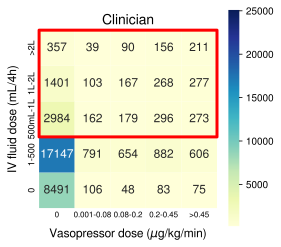

In [33]:
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(df_action_obs['a:action'].value_counts().sort_index().reindex(range(25), fill_value=0).values.reshape((5,5)), 
            ax=ax, square=True, cmap="YlGnBu", vmax=2.5e4, annot=True, fmt='d', annot_kws={"size": 12})
ax.invert_yaxis()

plt.title('Clinician', fontsize=14)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Vasopressor dose ($\mu$g/kg/min)", fontsize=12)
plt.ylabel("IV fluid dose (mL/4h)", fontsize=12)

xranges = ['0', '0.001-0.08', '0.08-0.2', '0.2-0.45', '>0.45']
yranges = ['0', '1-500', '500mL-1L', '1L-2L', '>2L']
for pos, text in enumerate(xranges):
    plt.text(pos+3/6, -0.2, text, fontsize=8, ha='center', va='center')
for pos, text in enumerate(yranges):
    plt.text(-0.2, pos+3/6, text, fontsize=9, ha='center', va='center', rotation='vertical')

plt.gca().add_patch(
    matplotlib.patches.Rectangle((0, 2), 5, 3, edgecolor='red', facecolor='none', lw=3, clip_on=False)
)

plt.savefig('./fig/mimic_test_policy_clinician.pdf', bbox_inches='tight')
plt.show()